In [ ]:
!pip install scikit-plot
!pip install catboost
!pip install eli5

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report


from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import re
import eli5
from eli5.sklearn import PermutationImportance

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.set_option('display.max_columns', None)

In [8]:
df = pd.read_csv('./drive/MyDrive/df_bezNAN.csv',index_col='Unnamed: 0')

In [ ]:
# df = pd.read_csv('./Dane/df_bezNan.csv',index_col='Unnamed: 0')

In [9]:
df

,Activity,angleXgravityMean,angleYgravityMean,angleZgravityMean,angletBodyAccJerkMeangravityMean,angletBodyAccMeangravity,angletBodyGyroJerkMeangravityMean,angletBodyGyroMeangravityMean,energymean,fBodyAccbandsEnergy116,fBodyAccbandsEnergy1161,fBodyAccbandsEnergy1162,fBodyAccbandsEnergy124,fBodyAccbandsEnergy1241,fBodyAccbandsEnergy1242,fBodyAccbandsEnergy18,fBodyAccbandsEnergy181,fBodyAccbandsEnergy182,fBodyAccbandsEnergy1724,fBodyAccbandsEnergy17241,fBodyAccbandsEnergy17242,fBodyAccbandsEnergy1732,fBodyAccbandsEnergy17321,fBodyAccbandsEnergy17322,fBodyAccbandsEnergy2532,fBodyAccbandsEnergy25321,fBodyAccbandsEnergy25322,fBodyAccbandsEnergy2548,fBodyAccbandsEnergy25481,fBodyAccbandsEnergy25482,fBodyAccbandsEnergy3340,fBodyAccbandsEnergy33401,fBodyAccbandsEnergy33402,fBodyAccbandsEnergy3348,fBodyAccbandsEnergy33481,fBodyAccbandsEnergy33482,fBodyAccbandsEnergy4148,fBodyAccbandsEnergy41481,fBodyAccbandsEnergy41482,fBodyAccbandsEnergy4956,fBodyAccbandsEnergy49561,fBodyAccbandsEnergy49562,fBodyAccbandsEnergy4964,fBodyAccbandsEnergy49641,fBodyAccbandsEnergy49642,fBodyAccbandsEnergy5764,fBodyAccbandsEnergy57641,fBodyAccbandsEnergy57642,fBodyAccbandsEnergy916,fBodyAccbandsEnergy9161,fBodyAccbandsEnergy9162,fBodyAccenergyX,fBodyAccenergyY,fBodyAccenergyZ,fBodyAccentropyX,fBodyAccentropyY,fBodyAccentropyZ,fBodyAcciqrX,fBodyAcciqrY,fBodyAcciqrZ,fBodyAcckurtosisX,fBodyAcckurtosisY,fBodyAcckurtosisZ,fBodyAccmadX,fBodyAccmadY,fBodyAccmadZ,fBodyAccmainX,fBodyAccmainY,fBodyAccmainZ,fBodyAccmaxX,fBodyAccmaxY,fBodyAccmaxZ,fBodyAccmaxIndsX,fBodyAccmaxIndsY,fBodyAccmaxIndsZ,fBodyAccmeanX,fBodyAccmeanY,fBodyAccmeanZ,fBodyAccmeanFreqX,fBodyAccmeanFreqY,fBodyAccmeanFreqZ,fBodyAccminX,fBodyAccminY,fBodyAccminZ,fBodyAccskewnessX,fBodyAccskewnessY,fBodyAccskewnessZ,fBodyAccsma,fBodyAccstdX,fBodyAccstdY,fBodyAccstdZ,fBodyAccJerkbandsEnergy116,fBodyAccJerkbandsEnergy1161,fBodyAccJerkbandsEnergy1162,fBodyAccJerkbandsEnergy124,fBodyAccJerkbandsEnergy1241,fBodyAccJerkbandsEnergy1242,fBodyAccJerkbandsEnergy18,fBodyAccJerkbandsEnergy181,fBodyAccJerkbandsEnergy182,fBodyAccJerkbandsEnergy1724,fBodyAccJerkbandsEnergy17241,fBodyAccJerkbandsEnergy17242,fBodyAccJerkbandsEnergy1732,fBodyAccJerkbandsEnergy17321,fBodyAccJerkbandsEnergy17322,fBodyAccJerkbandsEnergy2532,fBodyAccJerkbandsEnergy25321,fBodyAccJerkbandsEnergy25322,fBodyAccJerkbandsEnergy2548,fBodyAccJerkbandsEnergy25481,fBodyAccJerkbandsEnergy25482,fBodyAccJerkbandsEnergy3340,fBodyAccJerkbandsEnergy33401,fBodyAccJerkbandsEnergy33402,fBodyAccJerkbandsEnergy3348,fBodyAccJerkbandsEnergy33481,fBodyAccJerkbandsEnergy33482,fBodyAccJerkbandsEnergy4148,fBodyAccJerkbandsEnergy41481,fBodyAccJerkbandsEnergy41482,fBodyAccJerkbandsEnergy4956,fBodyAccJerkbandsEnergy49561,fBodyAccJerkbandsEnergy49562,fBodyAccJerkbandsEnergy4964,fBodyAccJerkbandsEnergy49641,fBodyAccJerkbandsEnergy49642,fBodyAccJerkbandsEnergy5764,fBodyAccJerkbandsEnergy57641,fBodyAccJerkbandsEnergy57642,fBodyAccJerkbandsEnergy916,fBodyAccJerkbandsEnergy9161,fBodyAccJerkbandsEnergy9162,fBodyAccJerkenergyX,fBodyAccJerkenergyY,fBodyAccJerkenergyZ,fBodyAccJerkentropyX,fBodyAccJerkentropyY,fBodyAccJerkentropyZ,fBodyAccJerkiqrX,fBodyAccJerkiqrY,fBodyAccJerkiqrZ,fBodyAccJerkkurtosisX,fBodyAccJerkkurtosisY,fBodyAccJerkkurtosisZ,fBodyAccJerkmadX,fBodyAccJerkmadY,fBodyAccJerkmadZ,fBodyAccJerkmaxX,fBodyAccJerkmaxY,fBodyAccJerkmaxZ,fBodyAccJerkmaxIndsX,fBodyAccJerkmaxIndsY,fBodyAccJerkmaxIndsZ,fBodyAccJerkmeanX,fBodyAccJerkmeanY,fBodyAccJerkmeanZ,fBodyAccJerkmeanFreqX,fBodyAccJerkmeanFreqY,fBodyAccJerkmeanFreqZ,fBodyAccJerkminX,fBodyAccJerkminY,fBodyAccJerkminZ,fBodyAccJerkskewnessX,fBodyAccJerkskewnessY,fBodyAccJerkskewnessZ,fBodyAccJerksma,fBodyAccJerkstdX,fBodyAccJerkstdY,fBodyAccJerkstdZ,fBodyAccMagenergy,fBodyAccMagentropy,fBodyAccMagiqr,fBodyAccMagkurtosis,fBodyAccMagmad,fBodyAccMagmax,fBodyAccMagmaxInds,fBodyAccMagmean,fBodyAccMagmeanFreq,fBodyAccMagmin,fBodyAccMagskewness,fBodyAccMagsma,fBodyAccMagstd,fBodyBodyAccJerkMagenergy,fBodyBodyAccJerkMagentropy,fBodyB

In [24]:
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'LGR': LogisticRegression(solver = 'lbfgs', random_state=42, verbose=0),
    'DTC': DecisionTreeClassifier(random_state=42),
    'RFC': RandomForestClassifier(random_state=42),
    'ETC': ExtraTreesClassifier(random_state=42),
    'XGB': xgb.XGBClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42),
    # 'CTB': ctb.CatBoostClassifier(verbose=0),
}

In [11]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

In [12]:
def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

In [13]:
def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred, average='micro')
    return score

In [14]:
def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 3, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [15]:
def split_data(df):
    feats = [feat for feat in df.columns if feat != 'Activity']
    
    X = df[feats]
    y = df['Activity']
    
    return X, y

In [16]:
df1 = df

In [22]:
def run_model(model, df, scoring):
    df = df.sample(frac=0.1)
    X, y = split_data(df)
    y = y.factorize()[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1_micro');    
    plt.show()

LGR


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[1 0 4 1 1 0 2 0 1 5 3 5 1 3 3 5 4 1 4 1 3 2 1 5 5 2 3 5 0 1 4 1 2 0 0 2 1
 4 5 3 1 1 0 3 1 4 2 5 5 5 1 4 4 3 1 0 5 3 0 2 3 1 2 4 1 3 1 3 2 0 4 3 3 0
 3 3 2 4 3 3 0 1 0 4 1 1 0 2 1 3 1 3 1 1 0 3 4 4 2 5 2 1 0 1 4 0 2 1 4 4 5
 0 3 4 0 0 5 5 5 3 5 4 2 5 5 3 2 5 5 1 3 5 4 2 3 3 1 5 4 5 2 1 2 1 2 2 3 4
 1 3 2 3 2 5 4 0 1 5 5 1 1 1 3 4 2 1 4 1 5 4 3 3 2 5 1 0 0 5 1 2 1 3 4 5 5
 4 3 5 1 5 2 1 4 3 5 0 5 2 0 4 3 4 5 3 4 2 4 4 3 3 5 5 5 4 1 4 1 5 0 1 1 3
 4 3 1 1 5 5 5 0 0 0 0 1 3 4 3 0 3 2 5 0 2 4 3 3 0 5 3 0 4 1 0 4 1 3 4 4 0
 5 1 1 2 1 3 0 2 3 4 0 1 1 2 0 0 0 4 5 3 4 3 4 5 4 2 0 4] 

accuracy:  0.9442508710801394
recall:  0.9442508710801394
precision:  0.9442508710801394
f1_micro:  0.9442508710801394
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.90      0.93      0.91        57
           2       1.00      0.92      0.96        38
           3       0.96      0.98      0.97        52
           4       1.00  

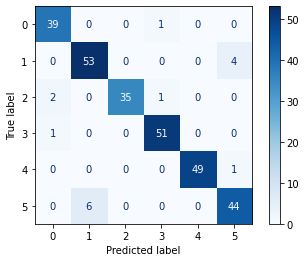

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


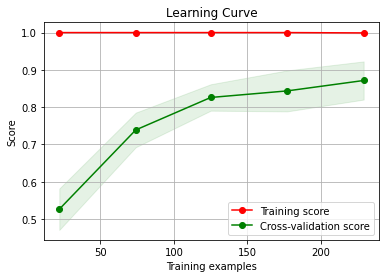

DTC
[2 0 3 1 1 3 2 0 1 3 4 4 1 2 3 4 4 0 5 1 4 4 4 2 2 2 0 5 0 0 1 0 5 5 0 3 1
 2 5 2 1 3 0 1 5 3 4 0 5 2 5 1 3 5 3 0 1 2 0 2 1 2 2 1 1 2 1 1 5 0 4 1 3 0
 2 1 4 3 2 0 1 0 2 1 1 0 2 4 3 1 2 0 0 5 4 4 4 4 3 1 0 3 5 0 2 1 4 4 2 0 2
 4 2 0 5 5 1 3 5 3 2 5 5 3 2 2 4 1 2 3 4 2 5 2 1 4 3 5 2 1 1 0 2 1 2 1 1 2
 1 2 1 3 0 1 4 4 1 1 1 4 2 4 4 0 5 3 2 1 5 0 0 0 3 1 2 1 5 4 4 3 3 2 5 4 3
 2 1 3 3 4 0 4 5 5 2 4 3 2 4 2 1 4 3 0 5 1 5 4 3 4 4 5 0 0 1 2 3 1 1 5 4 4
 0 3 0 0 1 3 3 5 0 3 2 5 0 2 3 3 2 0 5 3 1 4 0 0 4 1 3 1 2 1 3 0 4 5 1 5 2
 1 3 5 1 0 4 0 1 4 2 0 0 0 1 5 3 1 3 5 5 1 2 0 3 0 0 3 4] 

accuracy:  0.8885017421602788
recall:  0.8885017421602788
precision:  0.8885017421602788
f1_micro:  0.8885017421602788
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        53
           1       0.78      0.87      0.82        53
           2       1.00      1.00      1.00        50
           3       0.84      0.93      0.88        41
           4       0.

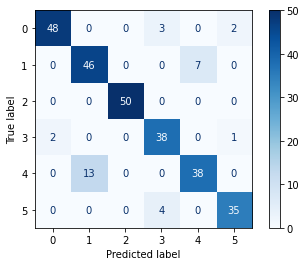

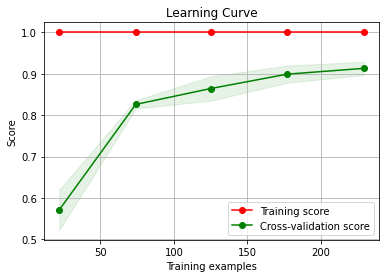

RFC
[3 0 3 3 2 3 0 5 1 1 0 2 0 1 2 5 2 4 3 2 5 0 5 0 2 4 0 0 0 0 0 4 1 2 2 2 4
 3 5 2 2 0 5 2 3 1 4 2 1 0 0 2 4 1 1 2 3 1 4 2 2 3 0 3 5 2 0 5 2 3 3 2 0 1
 0 2 0 0 5 5 0 1 5 0 3 2 4 3 2 3 0 0 3 4 0 2 1 5 3 2 0 4 5 0 5 5 4 2 5 2 5
 5 5 2 5 3 1 2 5 3 3 2 2 2 4 4 3 1 5 3 2 1 2 0 5 2 3 1 2 2 5 1 3 0 2 4 1 0
 4 4 2 1 5 0 3 3 2 2 5 0 3 5 1 2 1 3 4 4 5 4 2 5 1 5 2 1 3 4 0 5 4 5 2 4 3
 2 5 2 4 4 3 3 5 3 5 0 5 4 5 0 0 1 2 3 5 1 5 5 0 5 0 0 1 3 3 3 5 3 2 5 0 2
 3 3 2 0 5 3 2 4 0 0 4 1 3 4 2 1 3 0 3 5 1 4 5 2 0 2 1 3 5 2 0 0 4 2 2 0 4
 0 0 1 2 0 0 0 4 5 3 3 0 5 5 4 2 0 3 0 0 3 4 5 3 5 0 4 1] 

accuracy:  0.9616724738675958
recall:  0.9616724738675958
precision:  0.9616724738675958
f1_micro:  0.9616724738675958
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       1.00      0.89      0.94        36
           2       1.00      1.00      1.00        60
           3       0.94      0.96      0.95        49
           4       0.

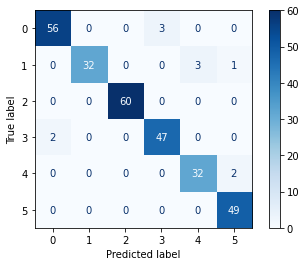

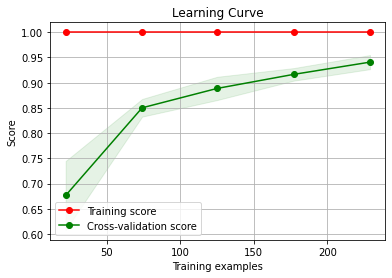

ETC
[1 5 4 1 1 0 2 0 1 5 3 5 1 2 3 5 2 1 4 1 3 2 1 5 5 2 3 5 0 1 4 3 2 3 5 2 5
 3 1 3 1 5 0 2 5 4 2 0 5 5 1 4 4 3 1 0 5 2 0 2 3 1 2 4 1 2 1 3 2 0 4 3 3 0
 4 3 2 4 3 2 0 1 0 4 1 1 0 2 1 3 1 3 0 1 3 3 4 4 2 5 4 1 0 5 4 0 2 1 4 4 5
 0 2 4 2 0 5 5 5 2 5 4 2 5 5 2 2 3 5 1 3 5 4 2 3 3 1 5 4 5 2 1 2 1 2 2 2 4
 1 3 2 3 2 1 4 0 4 0 5 1 1 1 3 4 4 1 4 0 5 4 2 3 2 5 0 0 0 5 1 2 1 3 2 5 5
 4 2 5 1 5 2 1 3 3 4 0 5 2 0 4 3 4 1 2 4 2 4 4 3 3 5 5 5 4 1 4 5 5 0 1 1 2
 4 3 1 1 5 5 4 0 0 0 0 1 3 3 3 0 3 2 5 0 4 4 3 2 0 5 3 2 4 1 0 4 1 0 4 4 0
 5 1 5 2 1 3 0 2 0 4 3 1 1 4 0 0 0 2 5 3 4 3 4 5 4 2 0 4] 

accuracy:  0.9442508710801394
recall:  0.9442508710801394
precision:  0.9442508710801394
f1_micro:  0.9442508710801394
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        45
           1       1.00      1.00      1.00        51
           2       0.94      0.89      0.91        53
           3       0.93      0.98      0.95        42
           4       0.

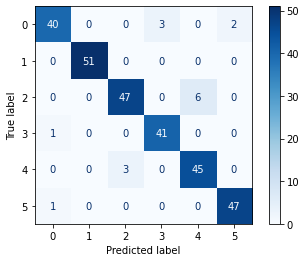

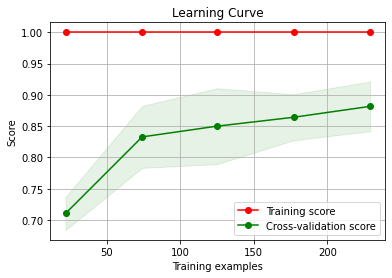

XGB
[2 0 3 5 1 4 2 4 1 3 1 5 1 2 3 4 4 5 5 1 4 5 1 2 2 2 3 5 0 1 1 1 0 0 0 5 2
 2 5 3 1 3 0 1 5 3 2 1 5 2 1 1 3 5 3 0 2 2 0 2 2 3 2 4 1 2 5 4 5 0 4 4 3 0
 2 4 5 3 2 0 1 0 2 1 1 0 2 1 4 1 2 1 1 5 2 4 4 1 4 1 0 3 5 0 2 1 4 4 2 0 2
 4 2 0 5 5 4 3 5 3 2 1 5 3 2 2 4 1 0 3 4 2 5 3 1 5 3 1 2 5 2 1 2 2 2 4 1 2
 2 2 1 3 0 2 3 5 1 1 1 5 2 5 4 1 5 3 2 2 5 1 0 0 4 2 2 1 1 4 5 3 5 2 5 1 5
 2 1 4 3 4 0 5 5 5 3 4 1 2 4 2 4 4 3 3 5 4 5 3 1 4 4 5 0 1 1 2 3 1 5 5 5 4
 0 5 0 0 1 3 3 3 0 3 2 5 0 2 3 3 2 0 5 3 2 4 1 0 4 1 3 5 2 1 3 0 4 5 1 5 2
 1 3 0 2 0 4 0 1 1 2 0 0 0 4 5 3 4 3 5 5 4 2 0 3 0 0 3 4] 

accuracy:  0.9337979094076655
recall:  0.9337979094076655
precision:  0.9337979094076655
f1_micro:  0.9337979094076655
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.89      0.91      0.90        53
           2       1.00      1.00      1.00        58
           3       1.00      0.90      0.95        48
           4       0.

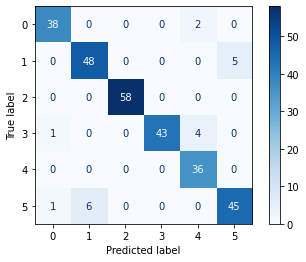

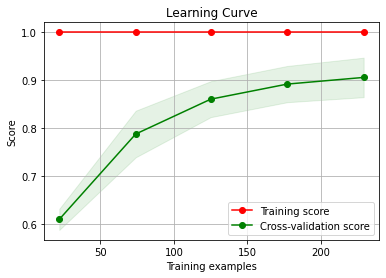

LGBM
[3 0 3 4 2 3 0 5 1 1 1 3 0 1 2 1 2 4 4 2 5 0 5 0 3 4 0 0 0 0 0 1 1 2 2 3 4
 3 1 2 1 0 5 2 4 1 5 3 1 0 0 2 4 1 1 2 3 1 4 1 2 4 2 4 5 2 0 5 2 3 4 2 0 1
 0 2 1 1 5 5 3 1 5 0 0 3 1 4 3 4 1 0 3 4 0 1 1 1 3 2 0 4 5 0 5 5 4 2 5 3 5
 5 5 2 5 3 5 3 5 3 4 3 2 3 4 4 3 1 5 3 2 1 2 0 5 2 4 5 2 2 5 1 3 0 1 5 5 1
 1 4 0 1 5 0 3 3 2 2 5 0 0 5 1 1 1 3 4 4 5 4 2 5 1 2 2 1 3 4 0 5 5 5 3 4 0
 3 1 2 4 4 3 3 5 4 5 0 5 4 5 2 1 1 3 3 5 5 5 4 0 5 0 0 1 3 4 3 5 3 2 5 0 2
 4 4 3 0 5 4 5 4 0 0 4 1 4 5 2 5 4 0 4 5 5 4 5 2 0 2 1 3 5 2 0 0 4 2 1 0 4
 0 1 1 2 0 0 0 4 5 3 4 3 5 5 4 2 0 4 0 0 4 4 5 4 5 0 4 1] 

accuracy:  0.9442508710801394
recall:  0.9442508710801394
precision:  0.9442508710801394
f1_micro:  0.9442508710801394
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.91      0.86      0.88        49
           2       0.93      0.93      0.93        41
           3       0.98      1.00      0.99        40
           4       1

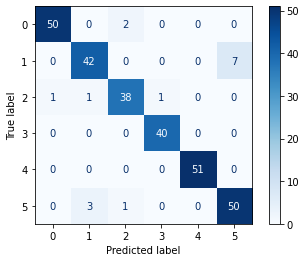

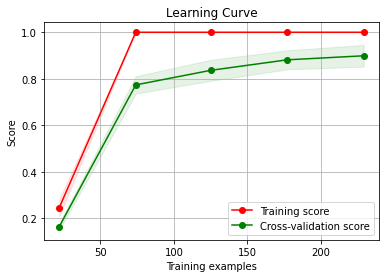

In [25]:
for model in models.items():
    print(model[0])
    run_model(model[1], df1, metrics['f1_score'])

In [26]:
X, y = split_data(df1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [92]:
model = models['LGBM']

In [93]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [94]:
imp = PermutationImportance(model, random_state = 42).fit(X_train, y_train)
eli5.show_weights(imp, feature_names = X_train.columns.values, top = 50)

Weight,Feature
0.0081 ± 0.0015,tGravityAccmaxY
0.0017 ± 0.0005,tGravityAccminX
0.0017 ± 0.0003,subject
0.0016 ± 0.0013,fBodyGyromaxIndsZ
0.0008 ± 0.0004,tBodyAcccorrelationXY
0.0006 ± 0.0004,tBodyGyromaxX
0.0001 ± 0.0001,fBodyGyromeanFreqX
0 ± 0.0000,fBodyAccJerkmeanFreqZ
0 ± 0.0000,fBodyBodyAccJerkMagstd
0 ± 0.0000,fBodyBodyGyroJerkMagenergy


In [45]:
very_small_feats = [
    'tGravityAccmaxY',
    'tGravityAccminX',
    'subject',
    'fBodyGyromaxIndsZ',
    'tBodyAcccorrelationXY',
    'tBodyGyromaxX',
    'fBodyGyromeanFreqX'
]

In [43]:
def split_data_sm(df):
    X = df[very_small_feats]
    y = df['Activity']
    return X, y

In [154]:
def run_model_sm(model, df, scoring):
    
    X, y = split_data_sm(df)
    y = y.factorize()[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1_micro');    
    plt.show()

LGR


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[3 4 0 ... 2 2 0] 

accuracy:  0.7627355198883461
recall:  0.7627355198883461
precision:  0.7627355198883461
f1_micro:  0.7627355198883461
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       527
           1       0.69      0.79      0.74       401
           2       0.95      0.96      0.95       534
           3       0.65      0.76      0.70       496
           4       0.84      0.83      0.84       535
           5       0.56      0.29      0.38       373

    accuracy                           0.76      2866
   macro avg       0.74      0.74      0.73      2866
weighted avg       0.76      0.76      0.75      2866



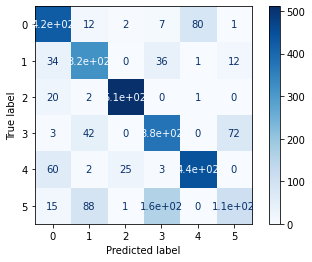

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


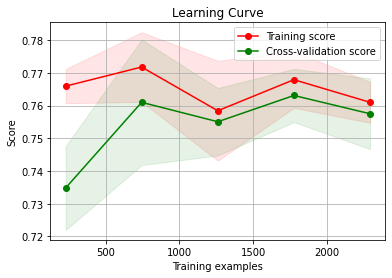

DTC
[5 4 0 ... 2 2 4] 

accuracy:  0.9403349616189811
recall:  0.9403349616189811
precision:  0.9403349616189811
f1_micro:  0.9403349616189811
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       527
           1       0.95      0.92      0.94       401
           2       1.00      1.00      1.00       534
           3       0.93      0.96      0.95       496
           4       0.92      0.93      0.93       535
           5       0.91      0.92      0.91       373

    accuracy                           0.94      2866
   macro avg       0.94      0.94      0.94      2866
weighted avg       0.94      0.94      0.94      2866



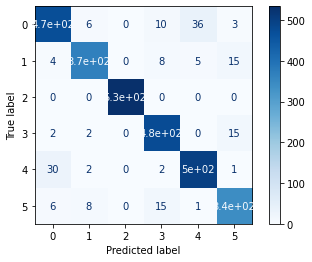

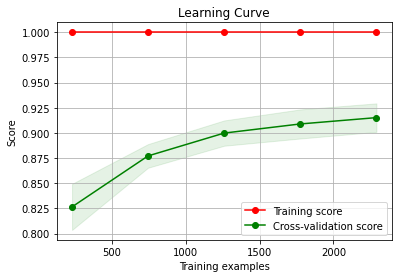

RFC
[5 4 0 ... 2 2 0] 

accuracy:  0.9619678995115143
recall:  0.9619678995115143
precision:  0.9619678995115143
f1_micro:  0.9619678995115143
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       527
           1       0.98      0.93      0.96       401
           2       1.00      1.00      1.00       534
           3       0.95      0.98      0.97       496
           4       0.96      0.96      0.96       535
           5       0.93      0.94      0.93       373

    accuracy                           0.96      2866
   macro avg       0.96      0.96      0.96      2866
weighted avg       0.96      0.96      0.96      2866



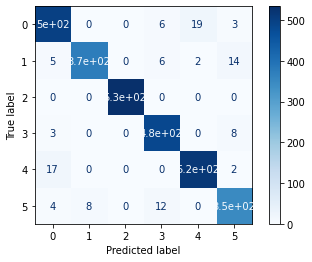

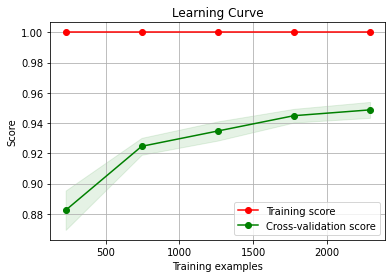

ETC
[5 4 0 ... 2 2 0] 

accuracy:  0.9762735519888346
recall:  0.9762735519888346
precision:  0.9762735519888346
f1_micro:  0.9762735519888346
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       527
           1       0.99      0.94      0.97       401
           2       1.00      1.00      1.00       534
           3       0.97      0.99      0.98       496
           4       0.98      0.98      0.98       535
           5       0.95      0.96      0.96       373

    accuracy                           0.98      2866
   macro avg       0.98      0.97      0.97      2866
weighted avg       0.98      0.98      0.98      2866



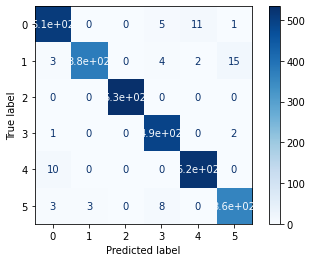

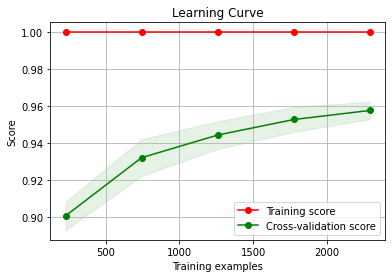

XGB
[5 4 0 ... 2 2 4] 

accuracy:  0.9528960223307746
recall:  0.9528960223307746
precision:  0.9528960223307746
f1_micro:  0.9528960223307746
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       527
           1       0.96      0.94      0.95       401
           2       1.00      1.00      1.00       534
           3       0.94      0.97      0.95       496
           4       0.94      0.96      0.95       535
           5       0.92      0.91      0.92       373

    accuracy                           0.95      2866
   macro avg       0.95      0.95      0.95      2866
weighted avg       0.95      0.95      0.95      2866



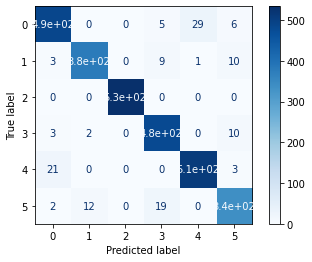

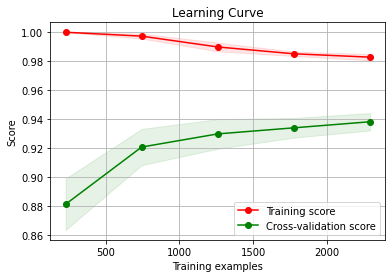

LGBM
[5 4 0 ... 2 2 0] 

accuracy:  0.9769713886950454
recall:  0.9769713886950454
precision:  0.9769713886950454
f1_micro:  0.9769713886950454
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       527
           1       0.98      0.96      0.97       401
           2       1.00      1.00      1.00       534
           3       0.97      0.99      0.98       496
           4       0.98      0.99      0.98       535
           5       0.95      0.95      0.95       373

    accuracy                           0.98      2866
   macro avg       0.98      0.98      0.98      2866
weighted avg       0.98      0.98      0.98      2866



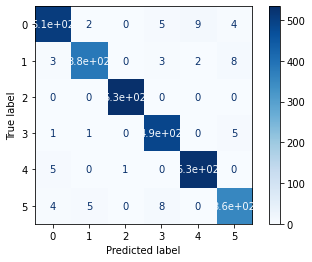

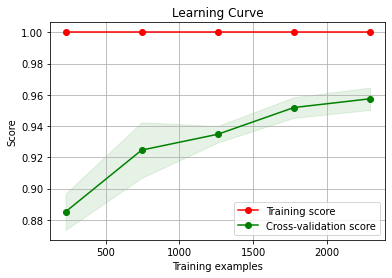

CTB
[[5]
 [4]
 [0]
 ...
 [2]
 [2]
 [0]] 

accuracy:  0.9787159804605722
recall:  0.9787159804605722
precision:  0.9787159804605722
f1_micro:  0.9787159804605722
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       527
           1       0.99      0.97      0.98       401
           2       1.00      1.00      1.00       534
           3       0.96      0.99      0.97       496
           4       0.98      0.99      0.98       535
           5       0.98      0.96      0.97       373

    accuracy                           0.98      2866
   macro avg       0.98      0.98      0.98      2866
weighted avg       0.98      0.98      0.98      2866



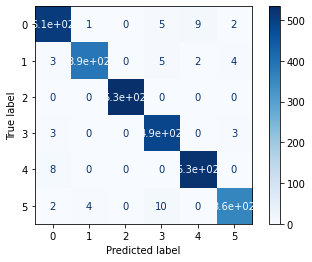

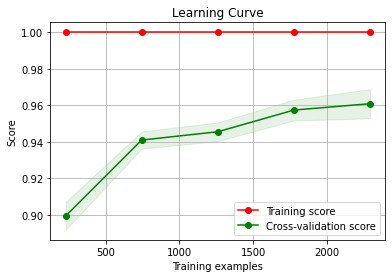

In [156]:
for model in models.items():
    print(model[0])
    run_model_sm(model[1], df1, metrics['f1_score'])

In [46]:
X, y = split_data_sm(df1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [215]:
def hyperopt():
    trials = Trials()
    
    space ={
        'max_depth': hp.quniform ('max_depth', 2, 8, 1),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
        'subsample': hp.uniform ('subsample', 0.8, 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.),
        'n_estimators': hp.quniform ('n_estimators', 10, 1000, 1),
        'random_state': 42,
    }
    
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=60,
                trials=trials)

    print("The best params: ", best_params)
    return trials.best_trial

def objective(space):
    
    params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'random_state': int(space['random_state']),
    }
    
    model = lgb.LGBMClassifier(**params)
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    score = score_model(y_test, y_pred, f1_score)
    
    return{'loss': -score, 'status': STATUS_OK }

In [216]:
hyperopt()

100%|██████████| 60/60 [03:29<00:00,  3.50s/it, best loss: -0.979413817166783]
The best params:  {'learning_rate': 0.21846825100335193, 'max_depth': 4.0, 'n_estimators': 508.0, 'reg_lambda': 0.9172053528319594, 'subsample': 0.9063808886712854}


{'book_time': datetime.datetime(2021, 4, 10, 9, 29, 40, 873000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'learning_rate': [27],
   'max_depth': [27],
   'n_estimators': [27],
   'reg_lambda': [27],
   'subsample': [27]},
  'tid': 27,
  'vals': {'learning_rate': [0.21846825100335193],
   'max_depth': [4.0],
   'n_estimators': [508.0],
   'reg_lambda': [0.9172053528319594],
   'subsample': [0.9063808886712854]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2021, 4, 10, 9, 29, 43, 694000),
 'result': {'loss': -0.979413817166783, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 27,
 'version': 0}

In [47]:
best_params =  {
    'learning_rate': 0.21846825100335193,
    'max_depth': 4,
    'n_estimators': 508,
    'reg_lambda': 0.9172053528319594,
    'subsample': 0.9063808886712854,
    'random_state': 42
}

In [48]:
best_model = lgb.LGBMClassifier(**best_params)

In [49]:
best_model = train_model(best_model, X_train, y_train)

In [50]:
y_pred_train = predict_model(best_model, X_train)

In [51]:
y_pred = predict_model(best_model, X_test)

In [52]:
np.mean(y_pred == y_test)

0.979413817166783

In [53]:
np.mean(y_pred_train == y_train)

1.0